
# Principal Component Regression vs Partial Least Squares Regression

cf https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html#

This example compares [Principal Component Regression](https://en.wikipedia.org/wiki/Principal_component_regression) (PCR) and
[Partial Least Squares Regression](https://en.wikipedia.org/wiki/Partial_least_squares_regression) (PLS) on a
toy dataset. Our goal is to illustrate how PLS can outperform PCR when the
target is strongly correlated with some directions in the data that have a
low variance.

PCR is a regressor composed of two steps: first,
:class:`~sklearn.decomposition.PCA` is applied to the training data, possibly
performing dimensionality reduction; then, a regressor (e.g. a linear
regressor) is trained on the transformed samples. In
:class:`~sklearn.decomposition.PCA`, the transformation is purely
unsupervised, meaning that no information about the targets is used. As a
result, PCR may perform poorly in some datasets where the target is strongly
correlated with *directions* that have low variance. Indeed, the
dimensionality reduction of PCA projects the data into a lower dimensional
space where the variance of the projected data is greedily maximized along
each axis. Despite them having the most predictive power on the target, the
directions with a lower variance will be dropped, and the final regressor
will not be able to leverage them.

PLS is both a transformer and a regressor, and it is quite similar to PCR: it
also applies a dimensionality reduction to the samples before applying a
linear regressor to the transformed data. The main difference with PCR is
that the PLS transformation is supervised. Therefore, as we will see in this
example, it does not suffer from the issue we just mentioned.


## The data

We start by creating a simple dataset with two features. Before we even dive
into PCR and PLS, we fit a PCA estimator to display the two principal
components of this dataset, i.e. the two directions that explain the most
variance in the data.



In [5]:
import matplotlib.pyplot as plt
import numpy as np
from munch import Munch

g = Munch()

from sklearn.decomposition import PCA

g.rng = np.random.RandomState(0)
g.n_samples = 500
g.cov = [[3, 3], [3, 4]]

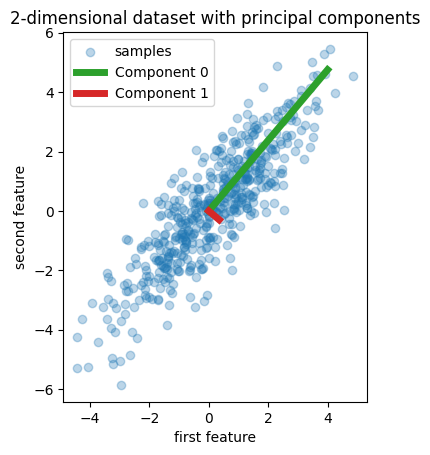

In [6]:
def compute_x_and_pca():
    g.X = g.rng.multivariate_normal(mean=[0, 0], cov=g.cov, size=g.n_samples)
    g.pca = PCA(n_components=2).fit(g.X)


def make_plot_1():
    fig, ax = plt.subplots()
    plt.scatter(g.X[:, 0], g.X[:, 1], alpha=0.3, label="samples")
    for i, (comp, var) in enumerate(zip(g.pca.components_, g.pca.explained_variance_)):
        comp = comp * var  # scale component by its variance explanation power
        plt.plot(
            [0, comp[0]],
            [0, comp[1]],
            label=f"Component {i}",
            linewidth=5,
            color=f"C{i + 2}",
        )
    plt.gca().set(
        aspect="equal",
        title="2-dimensional dataset with principal components",
        xlabel="first feature",
        ylabel="second feature",
    )
    plt.legend()
    g.plot1 = fig


def ensure_positive_semidefinite(matrix):
    """ Ensure that the covariance matrix is positive semi-definite by adjusting negative eigenvalues """
    from numpy.linalg import eigh
    eigvals, eigvecs = eigh(matrix)  # Compute the eigenvalues and eigenvectors
    eigvals = np.clip(eigvals, 1e-8, None)  # Ensure all eigenvalues are non-negative
    return eigvecs @ np.diag(eigvals) @ eigvecs.T  # Reconstruct the matrix

# initial computation
compute_x_and_pca()
make_plot_1()


### GUI with ipywidgets


In [7]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create sliders for covariance matrix and number of samples
n_samples_slider = widgets.IntSlider(value=g.n_samples, min=100, max=1000, step=1, description='Number of samples')
cov_00_slider = widgets.FloatSlider(value=g.cov[0][0], min=0.1, max=10, step=0.05, description='cov[0][0]')
cov_01_slider = widgets.FloatSlider(value=g.cov[0][1], min=0.1, max=10, step=0.05, description='cov[0][1]')
cov_10_slider = widgets.FloatSlider(value=g.cov[1][0], min=0.1, max=10, step=0.05, description='cov[1][0]')
cov_11_slider = widgets.FloatSlider(value=g.cov[1][1], min=0.1, max=10, step=0.05, description='cov[1][1]')

# Update function that will recompute and redraw when the sliders change
def update_plot(change=None):
    g.n_samples = n_samples_slider.value
    g.cov[0][0] = cov_00_slider.value
    g.cov[0][1] = cov_01_slider.value
    g.cov[1][0] = cov_10_slider.value
    g.cov[1][1] = cov_11_slider.value

    # Ensure the covariance matrix is valid
    g.cov = ensure_positive_semidefinite(g.cov)
    
    # Recompute the PCA and dataset
    compute_x_and_pca()
    
    # Redraw the plot
    with plot_output:
        clear_output(wait=True)
        make_plot_1()
        plt.show()

# Create a display output widget for the plot
plot_output = widgets.Output()

# Add event listeners for slider changes
n_samples_slider.observe(update_plot, 'value')
cov_00_slider.observe(update_plot, 'value')
cov_01_slider.observe(update_plot, 'value')
cov_10_slider.observe(update_plot, 'value')
cov_11_slider.observe(update_plot, 'value')

# Display the sliders and the plot
ui = widgets.VBox([n_samples_slider, cov_00_slider, cov_01_slider, cov_10_slider, cov_11_slider, plot_output])
display(ui)

# Initial plot rendering
update_plot()


For the purpose of this example, we now define the target `y` such that it is
strongly correlated with a direction that has a small variance. To this end,
we will project `X` onto the second component, and add some noise to it.



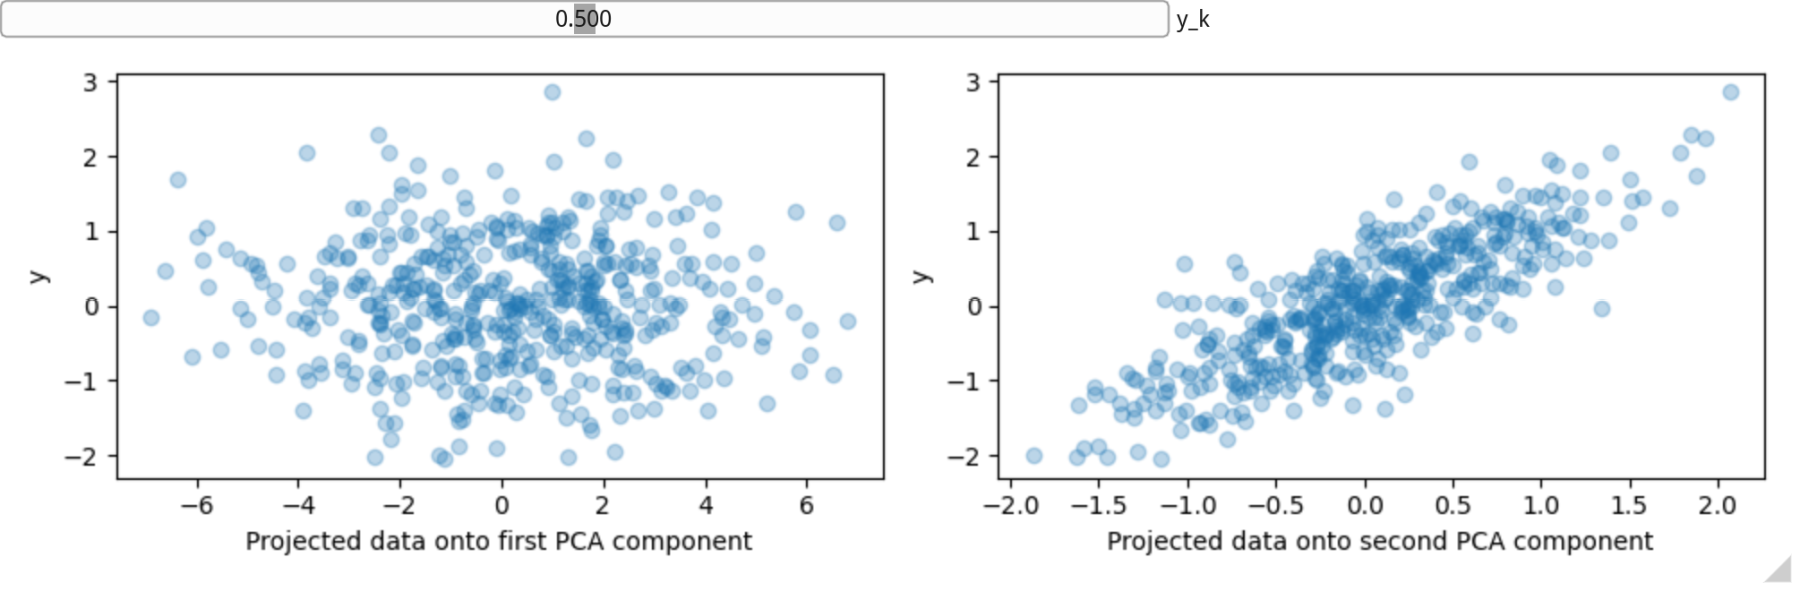

In [5]:
g.y_noise = 0.5

def compute_y():
    g.y = g.X.dot(g.pca.components_[1]) + g.rng.normal(size=g.n_samples) * g.y_noise


def make_plot_2():
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    axes[0].scatter(g.X.dot(g.pca.components_[0]), g.y, alpha=0.3)
    axes[0].set(xlabel="Projected data onto first PCA component", ylabel="y")
    axes[1].scatter(g.X.dot(g.pca.components_[1]), g.y, alpha=0.3)
    axes[1].set(xlabel="Projected data onto second PCA component", ylabel="y")
    plt.tight_layout()
    g.plot2 = fig

compute_y()
make_plot_2()


def gui2():
    changed, g.y_noise = imgui.slider_float("y_k", g.y_noise, 0, 1)
    if changed:
        compute_y()
        make_plot_2()
    imgui_fig.fig("Plot 2", g.plot2, refresh_image=changed)


immapp.run_nb(gui2, thumbnail_height=600)

## Projection on one component and predictive power

We now create two regressors: PCR and PLS, and for our illustration purposes
we set the number of components to 1. Before feeding the data to the PCA step
of PCR, we first standardize it, as recommended by good practice. The PLS
estimator has built-in scaling capabilities.

For both models, we plot the projected data onto the first component against
the target. In both cases, this projected data is what the regressors will
use as training data.



/var/folders/w1/w77kvvl9613022ksfxj7v8xh0000gn/T/ipykernel_40641/1837742360.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


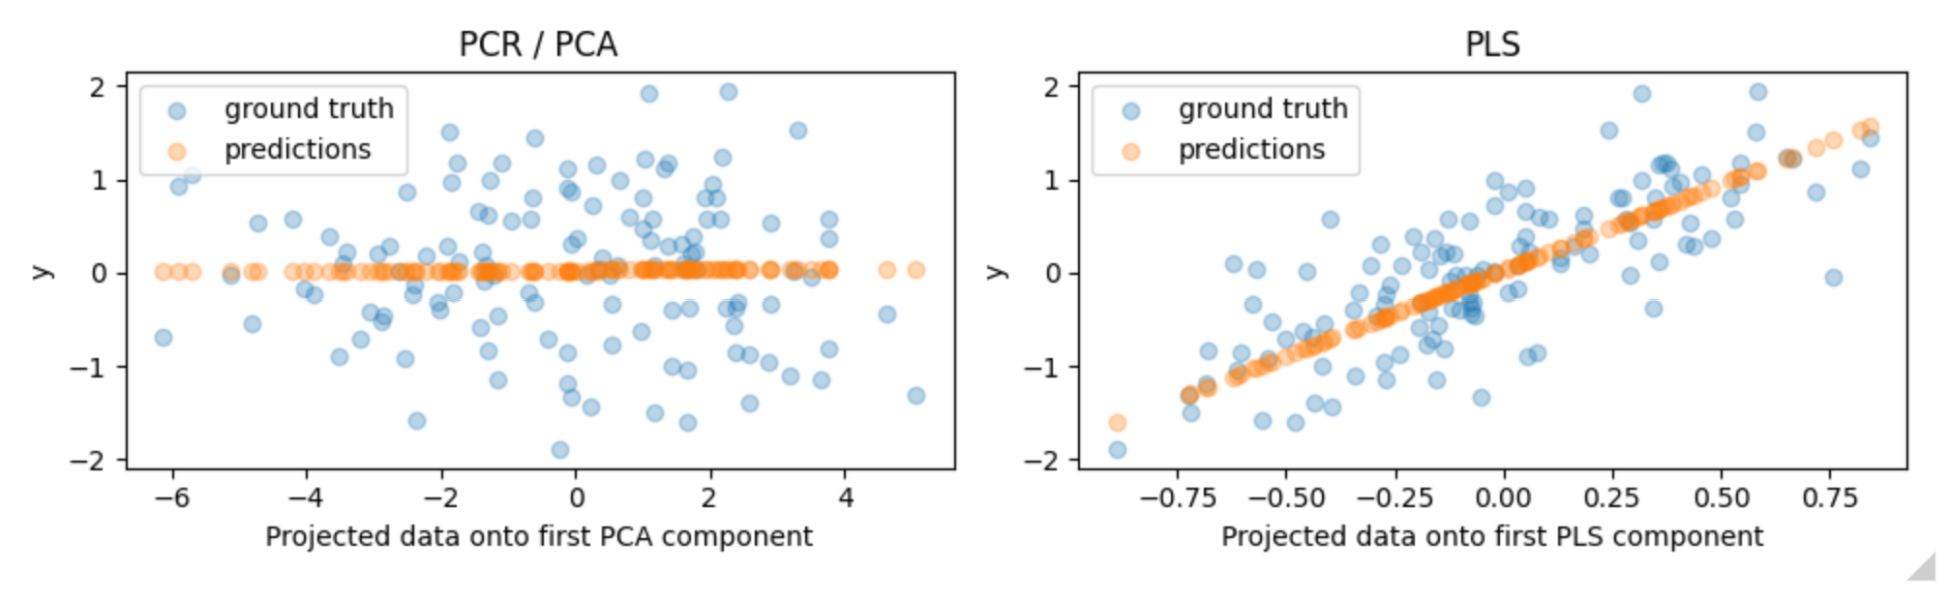

In [7]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

g.X_train, g.X_test, g.y_train, g.y_test = train_test_split(g.X, g.y, random_state=g.rng)

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(g.X_train, g.y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(g.X_train, g.y_train)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(g.X_test), g.y_test, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(g.X_test), pcr.predict(g.X_test), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(g.X_test), g.y_test, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(g.X_test), pls.predict(g.X_test), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="PLS")
axes[1].legend()
plt.tight_layout()

plt.show()

def gui3():
    imgui_fig.fig("Plot 3", fig)

immapp.run_nb(gui3, thumbnail_height=600)

As expected, the unsupervised PCA transformation of PCR has dropped the
second component, i.e. the direction with the lowest variance, despite
it being the most predictive direction. This is because PCA is a completely
unsupervised transformation, and results in the projected data having a low
predictive power on the target.

On the other hand, the PLS regressor manages to capture the effect of the
direction with the lowest variance, thanks to its use of target information
during the transformation: it can recognize that this direction is actually
the most predictive. We note that the first PLS component is negatively
correlated with the target, which comes from the fact that the signs of
eigenvectors are arbitrary.

We also print the R-squared scores of both estimators, which further confirms
that PLS is a better alternative than PCR in this case. A negative R-squared
indicates that PCR performs worse than a regressor that would simply predict
the mean of the target.



In [7]:
print(f"PCR r-squared {pcr.score(g.X_test, g.y_test):.3f}")
print(f"PLS r-squared {pls.score(g.X_test, g.y_test):.3f}")

PCR r-squared -0.013
PLS r-squared 0.692


As a final remark, we note that PCR with 2 components performs as well as
PLS: this is because in this case, PCR was able to leverage the second
component which has the most preditive power on the target.



In [10]:
pca_2 = make_pipeline(PCA(n_components=2), LinearRegression())
pca_2.fit(g.X_train, g.y_train)
print(f"PCR r-squared with 2 components {pca_2.score(g.X_test, g.y_test):.3f}")

PCR r-squared with 2 components 0.771


# An example with interact

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Define the function to plot
def plot_sine_cosine(a=1.0, b=1.0, c=1.0, d=1.0):
    x = np.linspace(0, 10, 400)
    y = a * np.sin(b * x) + c * np.cos(d * x)
    
    plt.figure(figsize=(8, 4))
    plt.plot(x, y, label=r"$y = a \sin(b x) + c \cos(d x)$")
    plt.title(f"Plot of y = {a} * sin({b} * x) + {c} * cos({d} * x)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.legend()
    plt.show()

# Create interactive sliders for the parameters a, b, c, and d
interact(
    plot_sine_cosine,
    a=widgets.FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1, description="a"),
    b=widgets.FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1, description="b"),
    c=widgets.FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1, description="c"),
    d=widgets.FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1, description="d"),
)


interactive(children=(FloatSlider(value=1.0, description='a', max=5.0), FloatSlider(value=1.0, description='b'…

<function __main__.plot_sine_cosine(a=1.0, b=1.0, c=1.0, d=1.0)>